<a href="https://colab.research.google.com/github/Musu1/Deep-Learning/blob/master/FFNetworkWithPyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,mean_squared_error,log_loss
from tqdm import tqdm_notebook
import seaborn as sns
import time
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs
import torch

In [99]:
torch.manual_seed(0)

In [0]:
#This is used to plot the labels
my_cmap=matplotlib.colors.LinearSegmentedColormap.from_list(" ",["red","yellow","green"])

In [101]:
# We have 1000 smaples with 2 features each and we use random_state=0 so that every time same data will be created
data,labels=make_blobs(n_samples=1000,centers=4,n_features=2,random_state=0)
print(data.shape,labels.shape)

(1000, 2) (1000,)


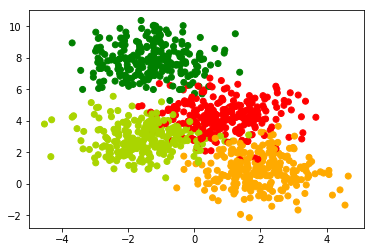

In [102]:
#Here x axix is one feature and y axis is second feature and cmap is mapping
plt.scatter(data[:,0],data[:,1],c=labels,cmap=my_cmap)
plt.show()

In [103]:
#Test train split in samples based on labels 
X_train,X_val,Y_train,Y_val=train_test_split(data,labels,stratify=labels,random_state=0)
print(X_train.shape,X_val.shape,labels.shape)

(750, 2) (250, 2) (1000,)


# Using torch tensors and Autograd

In [104]:
#Convert from np array to tensors
X_train,X_val,Y_train,Y_val=map(torch.tensor,(X_train,X_val,Y_train,Y_val))
print(X_train.shape,X_val.shape)

torch.Size([750, 2]) torch.Size([250, 2])


In [0]:
#Now here I am using a model with two layers one has 2 neuron and other has 4 neuron(which is final layer )

def model(x):
  a1=torch.matmul(x,weights1)+bias1 #Here shape of x --> N X 2(features) and shape of weights1 --> 2 x 2 then output would be N X 2 --> a1
  h1=a1.sigmoid() #Using sigmoid as activation function h1 --> (N,2)
  a2=torch.matmul(h1,weights2)+bias2 # Here shape of a2 --> (N,2) X (2,4) --> (N,4)
  h2=a2.exp()/a2.exp().sum(-1).unsqueeze(-1) # h2 is softmax function of a2 Softmax is exponent of a output divide by sum of all the exponents.See the softmax in the next code
  return h2
  

In [106]:
#Softmax function step by step
a=torch.randn([2,4])
print(a)
print(a.exp())
print(a.exp().sum(-1)) #here the sum parameter is -1 (it can be 1 also) which means we want the sum along row but the output is also a row we want a column
print(a.exp().sum(1))
print(a.exp().sum(-1).shape)
print(a.exp().sum(-1).unsqueeze(-1))
print(a.exp().sum(-1).unsqueeze(-1).shape)
print(a.exp()/a.exp().sum(-1).unsqueeze(-1))

tensor([[ 1.5410, -0.2934, -2.1788,  0.5684],
        [-1.0845, -1.3986,  0.4033,  0.8380]])
tensor([[4.6692, 0.7457, 0.1132, 1.7655],
        [0.3381, 0.2469, 1.4968, 2.3118]])
tensor([7.2936, 4.3936])
tensor([7.2936, 4.3936])
torch.Size([2])
tensor([[7.2936],
        [4.3936]])
torch.Size([2, 1])
tensor([[0.6402, 0.1022, 0.0155, 0.2421],
        [0.0769, 0.0562, 0.3407, 0.5262]])


In [0]:
# Defining loss so here we are using cross entropy loss
#Cross entropy loss means mean of -log(y_hat) that is for each input we will have some probability output(because of softmax) and maximum probability output would be
#our actual output and calculate the mean of all the -log(y_hat) that is for all the inputs.Look at it step by step
 
def loss_fn(y_hat,y):
  return (-y_hat[range(y_hat.shape[0]),y].log()).mean()

In [108]:
#.shape will give the size of y_hat and range would be from 0 to that shape-1  and then it would be y_hat[0,y[0]] and so on
y_hat=torch.tensor([[0.1,0.2,0.3,0.4],[0.8,0.1,0.05,0.05]])
y = torch.tensor([2,0])
print((-y_hat[range(y_hat.shape[0]),y].log()).mean().item())
print((torch.argmax(y_hat,dim=1)==y).float().mean().item())

0.7135581970214844
0.5


In [0]:
def accuracy(y_hat,y):
  pred=torch.argmax(y_hat,dim=1) #calculate the index of max argument along each row and it is in pred
  return (pred==y).float().mean() #Y_hat==y will give us the output either 0 0r 1 and then we take mean

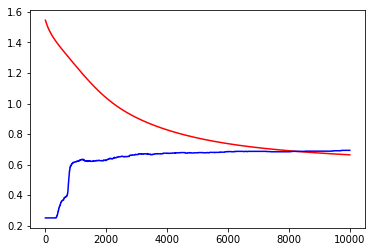

Loss before training 1.5456441640853882
Loss after training 0.6639549732208252


In [110]:
# Here I am using 2 layer neural network that is one hidden layer with two neuron and final layer has 4 neuron 

torch.manual_seed(0)

weights1=torch.randn(2,2)/math.sqrt(2) # Xavior initialization method as we are used sigmoid activation function
weights1.requires_grad_()
bias1=torch.zeros(2,requires_grad=True)

weights2=torch.randn(2,4)/math.sqrt(2)
weights2.requires_grad_()
bias2=torch.zeros(4,requires_grad=True)

learning_rate=0.01
epochs=10000

X_train=X_train.float()
Y_train=Y_train.long() #Here we are not converting to float because while calculating loss we are using y as an index for y_hat and it can't be float so it's long

loss_arr=[] #This is for book keeping to visualize the change
acc_arr=[]

for epoch in range(epochs):
  y_hat=model(X_train)
  loss=loss_fn(y_hat,Y_train)
  loss.backward()
  loss_arr.append(loss.item())
  acc_arr.append(accuracy(y_hat,Y_train))
  
  with torch.no_grad():
    weights1 -= weights1.grad * learning_rate
    bias1 -= bias1.grad * learning_rate
    weights2 -= weights2.grad * learning_rate
    bias2 -= bias2.grad * learning_rate
    weights1.grad.zero_()
    weights2.grad.zero_()
    bias1.grad.zero_()
    bias2.grad.zero_()
     
plt.plot(loss_arr,'-r')
plt.plot(acc_arr,'-b')
plt.show()
print('Loss before training',loss_arr[0])
print('Loss after training',loss_arr[-1])

# Using NN Sequential

In [0]:
import torch.nn.functional as F

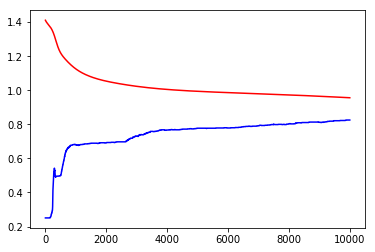

Loss before training 1.4111980199813843
Loss after training 0.9561843872070312


In [112]:
#In this we are just going to change the manually defined loss function with the cross entropy function and it will improve the training

torch.manual_seed(0)

weights1=torch.randn(2,2)/math.sqrt(2) # Xavior initialization method as we are used sigmoid activation function
weights1.requires_grad_()
bias1=torch.zeros(2,requires_grad=True)

weights2=torch.randn(2,4)/math.sqrt(2)
weights2.requires_grad_()
bias2=torch.zeros(4,requires_grad=True)

learning_rate=0.2
epochs=10000

X_train=X_train.float()
Y_train=Y_train.long() #Here we are not converting to float because while calculating loss we are using y as an index for y_hat and it can't be float so it's long

loss_arr=[] #This is for book keeping to visualize the change
acc_arr=[]

for epoch in range(epochs):
  y_hat=model(X_train)
  loss=F.cross_entropy(y_hat,Y_train)
  loss.backward()
  loss_arr.append(loss.item())
  acc_arr.append(accuracy(y_hat,Y_train))
  
  with torch.no_grad():
    weights1 -= weights1.grad * learning_rate
    bias1 -= bias1.grad * learning_rate
    weights2 -= weights2.grad * learning_rate
    bias2 -= bias2.grad * learning_rate
    weights1.grad.zero_()
    weights2.grad.zero_()
    bias1.grad.zero_()
    bias2.grad.zero_()
     
plt.plot(loss_arr,'-r')
plt.plot(acc_arr,'-b')
plt.show()
print('Loss before training',loss_arr[0])
print('Loss after training',loss_arr[-1])

# Using NN.parameter

In [0]:
# Here our model will inherit nn.module. It will have three advantages:
#      1. Instead of doing computation on each weight and bias manually we are mapping them in a nn.parameter and we can directly do computations on that
#      2. Similarly while resetting them to zero we can directly do on nn.parameter
#      3. Also it makes our fit function independent that is by changing number neurons or layers we won't have to change the fit fxn and only our model needs to be
#         updated


In [0]:
import torch.nn as nn

In [0]:
# Here my First_network is inheriting from nn.module

class First_network(nn.Module):
  
  def __init__(self):
    super().__init__() # Inherited class __init__ fxn
    torch.manual_seed(0)
    self.weights1=nn.Parameter(torch.randn(2,2)/math.sqrt(2))
    self.bias1=nn.Parameter(torch.zeros(2))
    self.weights2=nn.Parameter(torch.randn(2,4)/math.sqrt(2))
    self.bias2=nn.Parameter(torch.zeros(4))
    
  def forward(self,x):
     a1=torch.matmul(x,self.weights1)+self.bias1 #Here shape of x --> N X 2(features) and shape of weights1 --> 2 x 2 then output would be N X 2 --> a1
     h1=a1.sigmoid() #Using sigmoid as activation function h1 --> (N,2)
     a2=torch.matmul(h1,self.weights2)+self.bias2 # Here shape of a2 --> (N,2) X (2,4) --> (N,4)
     h2=a2.exp()/a2.exp().sum(-1).unsqueeze(-1) # h2 is softmax function of a2 Softmax is exponent of a output divide by sum of all the exponents.See the softmax in the next code
     return h2
    

In [0]:
def fit(epochs=1000 ,learning_rate=1):
  loss_arr=[] #This is for book keeping to visualize the change
  acc_arr=[]
  for epoch in range(epochs):
    y_hat=fn(X_train) # fn is defined below it will call the forward fxn from First_network class
    loss=F.cross_entropy(y_hat,Y_train)
    loss.backward()
    loss_arr.append(loss.item())
    acc_arr.append(accuracy(y_hat,Y_train))
    
    with torch.no_grad():
      for param in fn.parameters():
        param-=learning_rate*param.grad # This is how fit fxn becomes independent of model
      fn.zero_grad()
      
  plt.plot(loss_arr,'-r')
  plt.plot(acc_arr,'-b')
  plt.show()
  print('Loss before training',loss_arr[0])
  print('Loss after training',loss_arr[-1])

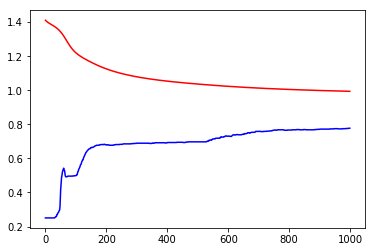

Loss before training 1.4111980199813843
Loss after training 0.9939236044883728


In [116]:
fn=First_network() 
fit()

# Using NN.linear and Optim

In [0]:
# Linear is basically abstraction only. Here we are encapsulating the weight bias initialization using nn.Linear and also we are commonly using matmul fxn so this
# nn.Linear does that for us

class FirstNetwork_v1(nn.Module):
  
  def __init__(self):
    super().__init__()
    torch.manual_seed(0)
    self.lin1=nn.Linear(2,2) # So here lin1 automatically initialize bias and weights and do the matmul operation and pass in lin1
    self.lin2=nn.Linear(2,4)
    
  def forward(self,x):
    a1=self.lin1(x)
    h1=a1.sigmoid()
    a2=self.lin2(h1)
    h2=a2.exp()/a2.exp().sum(-1).unsqueeze(-1)
    return h2

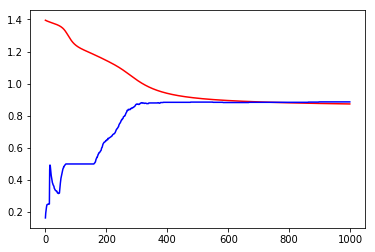

Loss before training 1.395160436630249
Loss after training 0.8738410472869873


In [118]:
fn=FirstNetwork_v1()
fit()

In [0]:
from torch import optim

In [0]:
# In this we can use different optimizers like SGD(stochastic gradient descent) ,nestrov etc
# Also here instead of updating the weights manually and setting them to zero we just optim.step andoptim.zero_grad fxns

def fit_v1(epochs=1000,learning_rate=1):
  
  loss_arr = []
  acc_arr = []
  
  opt=optim.SGD(fn.parameters(),lr=learning_rate)
  
  for epoch in range(epochs):
    y_hat=fn(X_train) # fn is defined below it will call the forward fxn from First_network class
    loss=F.cross_entropy(y_hat,Y_train)
    loss.backward()
    loss_arr.append(loss.item())
    acc_arr.append(accuracy(y_hat,Y_train))
    
    opt.step()
    opt.zero_grad()
      
  plt.plot(loss_arr,'-r')
  plt.plot(acc_arr,'-b')
  plt.show()
  print('Loss before training',loss_arr[0])
  print('Loss after training',loss_arr[-1])
  
               

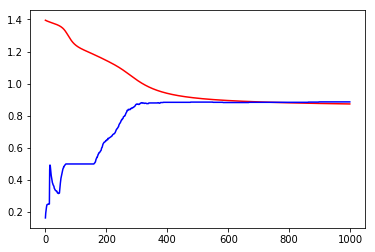

Loss before training 1.395160436630249
Loss after training 0.8738410472869873


In [121]:
fn=FirstNetwork_v1()
fit_v1()

# Using NN.sequential

In [0]:
#In this we define a net and can mention activation fxns directly instead of manual calcculations

class FirstNetwork_v2(nn.Module):
  def __init__(self):
    super().__init__()
    torch.manual_seed(0)
    self.net=nn.Sequential(nn.Linear(2,2),nn.Sigmoid(),nn.Linear(2,4),nn.Softmax())
  def forward(self,x):
    return self.net(x)
    

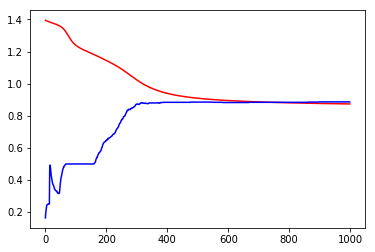

Loss before training 1.395160436630249
Loss after training 0.8738410472869873


In [123]:
fn=FirstNetwork_v2()
fit_v1()

In [0]:
# Now we just remove all the bookkeeping of loss and accuracy and also define fit with parameters

def fit_v2(x,y,model,opt,loss_fn,epochs=1000):
  
  for epoch in range(epochs):
    loss=loss_fn(model(x),y)
    loss.backward()
    opt.step()
    opt.zero_grad()
  
  return loss.item()

In [125]:
fn=FirstNetwork_v2()
loss_fn=F.cross_entropy
opt=optim.SGD(fn.parameters(),lr=1)
fit_v2(X_train,Y_train,fn,opt,loss_fn)

0.8738410472869873

# Migrating to Cuda

In [126]:
# First running on cpu

device=torch.device("cpu")

X_train=X_train.to(device)
Y_train=Y_train.to(device)
fn=FirstNetwork_v2()
fn.to(device)
tic=time.time()
print('Final Loss',fit_v2(X_train,Y_train,fn,opt,loss_fn))
toc=time.time()
print('Time taken',toc-tic)

Final Loss 1.395160436630249
Time taken 0.9244153499603271


In [127]:
# Now running on gpu Note here since we have a smaller model not much difference can be seen but if we have a bigger model it would be much more efficient

device=torch.device("cuda")

X_train=X_train.to(device)
Y_train=Y_train.to(device)
fn=FirstNetwork_v2()
fn.to(device)
tic=time.time()
print('Final Loss',fit_v2(X_train,Y_train,fn,opt,loss_fn))
toc=time.time()
print('Time taken',toc-tic)

Final Loss 1.3951594829559326
Time taken 0.9155826568603516
